In [1]:
# importing libraries
import numpy  as np
import random            as rand                     # random number gen
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler

# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects

# new packages
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# specifying file name
file = './Apprentice_Chef_Dataset.xlsx'


# reading the file into Python
apprentice_chef = pd.read_excel(file)

In [2]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [3]:
########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [4]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')




In [5]:
# using .shape to view (ROWS, COLUMNS)
apprentice_chef.shape


(1946, 28)

In [6]:
print(apprentice_chef.columns)

Index(['REVENUE', 'CROSS_SELL_SUCCESS', 'NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED'], dtype='object')


In [7]:
apprentice_chef.head(n = 5) # Checking content of the DF

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205


In [8]:
apprentice_chef.info() # CHECKING  TYPE OF EACH FEATURE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   REVENUE                      1946 non-null   float64
 1   CROSS_SELL_SUCCESS           1946 non-null   int64  
 2   NAME                         1946 non-null   object 
 3   EMAIL                        1946 non-null   object 
 4   FIRST_NAME                   1946 non-null   object 
 5   FAMILY_NAME                  1899 non-null   object 
 6   TOTAL_MEALS_ORDERED          1946 non-null   int64  
 7   UNIQUE_MEALS_PURCH           1946 non-null   int64  
 8   CONTACTS_W_CUSTOMER_SERVICE  1946 non-null   int64  
 9   PRODUCT_CATEGORIES_VIEWED    1946 non-null   int64  
 10  AVG_TIME_PER_SITE_VISIT      1946 non-null   float64
 11  MOBILE_NUMBER                1946 non-null   int64  
 12  CANCELLATIONS_BEFORE_NOON    1946 non-null   int64  
 13  CANCELLATIONS_AFTE

In [9]:
apprentice_chef['log_REVENUE'] = np.log10(apprentice_chef['REVENUE'])
apprentice_chef.describe(include = [int, float]).round(2)

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE
count,1946.00,1946.00,1946.00,1946.0,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00
mean,2107.29,0.68,74.63,4.9,6.98,5.38,99.60,0.88,1.40,0.17,0.71,5.52,1.48,11.33,1.49,2.97,0.36,0.11,150.56,4.44,0.60,2.79,13.51,106.43,3.27
std,1138.29,0.47,55.31,2.5,2.28,3.04,62.34,0.33,1.55,0.43,0.45,0.58,0.53,13.57,2.32,2.74,0.48,0.32,49.45,1.55,0.64,0.76,2.33,181.01,0.21
min,131.00,0.00,11.00,1.0,1.00,1.00,10.33,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,33.40,1.00,0.00,1.00,5.00,0.00,2.12
25%,1350.00,0.00,39.00,3.0,5.00,3.00,72.00,1.00,0.00,0.00,0.00,5.00,1.00,1.00,0.00,1.00,0.00,0.00,114.40,3.00,0.00,2.00,12.00,0.00,3.13
50%,1740.00,1.00,60.00,5.0,7.00,5.00,94.16,1.00,1.00,0.00,1.00,6.00,1.00,7.00,0.00,2.00,0.00,0.00,145.60,4.00,1.00,3.00,13.00,0.00,3.24
75%,2670.00,1.00,95.00,7.0,8.00,8.00,117.29,1.00,2.00,0.00,1.00,6.00,2.00,13.00,3.00,4.00,1.00,0.00,173.78,5.00,1.00,3.00,15.00,174.00,3.43
max,8793.75,1.00,493.00,19.0,18.00,10.00,1645.60,1.00,13.00,3.00,1.00,7.00,3.00,52.00,9.00,19.00,1.00,1.00,564.20,11.00,3.00,5.00,19.00,1600.00,3.94


In [10]:
apprentice_chef = apprentice_chef.rename(columns={'LARGEST_ORDER_SIZE': 'AVERAGE_ORDER_SIZE'}) #RENAMING LABEL LARGE FOR AVERAGE

#CONTINUOUS
----------

REVENUE,
AVG_TIME_PER_SITE_VISIT,
AVG_PREP_VID_TIME,
TOTAL_MEALS_ORDERED,
TOTAL_PHOTOS_VIEWED,
WEEKLY_PLAN,
UNIQUE_MEALS_PURCH,


#INTERVAL/COUNT
--------------
CONTACTS_W_CUSTOMER_SERVICE,
PC_LOGINS,
MOBILE_LOGINS,
CANCELLATIONS_BEFORE_NOON,
CANCELLATIONS_AFTER_NOON,
MASTER_CLASSES_ATTENDED,
MEDIAN_MEAL_RATING,

EARLY_DELIVERIES,
LATE_DELIVERIES,

AVERAGE_ORDER_SIZE,
AVG_CLICKS_PER_VISIT,
PRODUCT_CATEGORIES_VIEWED,

#CATEGORICAL
-----------
NAME,
EMAIL,
FIRST_NAME,
FAMILY_NAME,
CROSS_SELL_SUCCESS,
MOBILE_NUMBER,
PACKAGE_LOCKER,
REFRIGERATED_LOCKER,
TASTES_AND_PREFERENCES,

-----------

In [11]:
apprentice_chef.isnull().sum(axis = 0) # We check for null values, onyl null values on family name which is a feature we wont use 

REVENUE                         0
CROSS_SELL_SUCCESS              0
NAME                            0
EMAIL                           0
FIRST_NAME                      0
FAMILY_NAME                    47
TOTAL_MEALS_ORDERED             0
UNIQUE_MEALS_PURCH              0
CONTACTS_W_CUSTOMER_SERVICE     0
PRODUCT_CATEGORIES_VIEWED       0
AVG_TIME_PER_SITE_VISIT         0
MOBILE_NUMBER                   0
CANCELLATIONS_BEFORE_NOON       0
CANCELLATIONS_AFTER_NOON        0
TASTES_AND_PREFERENCES          0
PC_LOGINS                       0
MOBILE_LOGINS                   0
WEEKLY_PLAN                     0
EARLY_DELIVERIES                0
LATE_DELIVERIES                 0
PACKAGE_LOCKER                  0
REFRIGERATED_LOCKER             0
AVG_PREP_VID_TIME               0
AVERAGE_ORDER_SIZE              0
MASTER_CLASSES_ATTENDED         0
MEDIAN_MEAL_RATING              0
AVG_CLICKS_PER_VISIT            0
TOTAL_PHOTOS_VIEWED             0
log_REVENUE                     0
dtype: int64

In [12]:
# STEP 1: splitting personal emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in apprentice_chef.iterrows():
    
    # splitting email domain at '@'
    split_email = apprentice_chef.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


# displaying the results
email_df
#changing names
email_df.columns = ['0' , 'email_domain']

In [13]:
# email domain types
personal_email_domains = ['gmail.com', 'yahoo.com','protonmail.com' ]
junk_email_domains=['msn.com','aol.com','hotmail.com','live.com']

# placeholder list
placeholder_lst = []


# looping to group observations by domain type
for domain in email_df['email_domain']:
    
    if  domain in personal_email_domains:
        placeholder_lst.append('personal')
    
    elif domain in junk_email_domains:
        placeholder_lst.append('junk')    

    else:
        placeholder_lst.append('professional')

# concatenating with original DataFrame
email_df['domain_group'] = pd.Series(placeholder_lst)


# checking results
email_df['domain_group'].value_counts()

personal        861
professional    819
junk            266
Name: domain_group, dtype: int64

In [14]:
#we append the type of mail to our original use by the client on their registration to the DF and change the name to TYPE_MAIL

TYPE_MAIL=email_df['domain_group']
apprentice_chef=apprentice_chef.join(TYPE_MAIL)
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,domain_group
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional


In [15]:
apprentice_chef = apprentice_chef.rename(columns={'domain_group': 'TYPE_MAIL'})

In [16]:
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,TYPE_MAIL
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional


In [17]:
#CREATING NEW FLAG COLUMN AVERAGE ORDER SIZE TO CLASSIFIY: SMALL, MEDIUM, LARGE 

apprentice_chef['AVERAGE_ORDER_SIZE'].value_counts()


apprentice_chef['ORDER_SIZE']     = 0

for index, value in apprentice_chef.iterrows():
    
    # Total_Photos Viewed
    if (apprentice_chef.loc[index, 'AVERAGE_ORDER_SIZE'] > 0) and (apprentice_chef.loc[index, 'AVERAGE_ORDER_SIZE'] <4):
        apprentice_chef.loc[index, 'ORDER_SIZE'] = 'SMALL'
    elif (apprentice_chef.loc[index, 'AVERAGE_ORDER_SIZE'] > 4) and (apprentice_chef.loc[index, 'AVERAGE_ORDER_SIZE']<7):
        apprentice_chef.loc[index, 'ORDER_SIZE'] = 'MEDIUM'
    else:
         apprentice_chef.loc[index, 'ORDER_SIZE'] = 'LARGE'
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,TYPE_MAIL,ORDER_SIZE
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional,SMALL
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional,SMALL
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional,SMALL
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional,SMALL
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional,SMALL


In [18]:
apprentice_chef['ORDER_SIZE'].value_counts() # checking the results 

LARGE     718
MEDIUM    685
SMALL     543
Name: ORDER_SIZE, dtype: int64

In [19]:
#HARDOCING THE GENDER LIST OF COSTUMERS
GENDER=['female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'female',
'female',
'female',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'male',
'male',
'female',
'female',
'female',
'male',
'male',
'female',
'female',
'female',
'female',
'male',
'male',
'female',
'male',
'female',
'male',
'male',
'male',
'female',
'female',
'male',
'female',
'female',
'male',
'male',
'male',
'female',
'male',
'male',
'male',
'male',
'male',
'female',
'female',
'male',
'male',
'male',
'male',
'male',
'male',
'female',
'male',
'male',]

In [20]:
#APPENDING GENDER LIST TO OUR DATA FRAME 
apprentice_chef['GENDER'] = pd.Series(GENDER)

In [21]:
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,TYPE_MAIL,ORDER_SIZE,GENDER
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional,SMALL,female
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional,SMALL,male
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional,SMALL,female
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional,SMALL,male
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional,SMALL,male


In [22]:
# creating a list of continuous features (including log_Revenue)
continuous_data = ['CROSS_SELL_SUCCESS','log_REVENUE','AVG_TIME_PER_SITE_VISIT','AVG_PREP_VID_TIME',
                    'TOTAL_MEALS_ORDERED','TOTAL_PHOTOS_VIEWED','WEEKLY_PLAN','UNIQUE_MEALS_PURCH']


# developing a correlation matrix based on continuous features
chef_corr = apprentice_chef[continuous_data].corr(method = 'pearson')


# filtering the results to only show correlations with CROSS_SELL_SUCESS
chef_corr.loc[ : ,'CROSS_SELL_SUCCESS'].round(decimals = 2).sort_values(ascending = False)

CROSS_SELL_SUCCESS         1.00
AVG_PREP_VID_TIME          0.03
log_REVENUE                0.01
AVG_TIME_PER_SITE_VISIT    0.01
TOTAL_MEALS_ORDERED        0.01
TOTAL_PHOTOS_VIEWED        0.01
UNIQUE_MEALS_PURCH         0.00
WEEKLY_PLAN               -0.01
Name: CROSS_SELL_SUCCESS, dtype: float64

In [23]:
#CONVERTING variables with no zero values  to log 

apprentice_chef['log_TOTAL_MEALS_ORDERED'] = np.log10(apprentice_chef['TOTAL_MEALS_ORDERED'])
apprentice_chef['log_AVG_PREP_VID_TIME'] = np.log10(apprentice_chef['AVG_PREP_VID_TIME'])
apprentice_chef['log_AVG_TIME_PER_SITE_VISIT'] = np.log10(apprentice_chef['AVG_TIME_PER_SITE_VISIT'])
apprentice_chef['log_UNIQUE_MEALS_PURCH'] = np.log10(apprentice_chef['UNIQUE_MEALS_PURCH'])


In [24]:
continuous_log_data = ['CROSS_SELL_SUCCESS','log_REVENUE','log_AVG_TIME_PER_SITE_VISIT','log_AVG_PREP_VID_TIME',
                    'log_TOTAL_MEALS_ORDERED','TOTAL_PHOTOS_VIEWED','WEEKLY_PLAN','log_UNIQUE_MEALS_PURCH']

# developing a correlation matrix based on continuous log features
chef_corr_log = apprentice_chef[continuous_log_data].corr(method = 'pearson')


# filtering the results to only show correlations with Sale_Price
chef_corr_log.loc[ : , 'CROSS_SELL_SUCCESS'].round(decimals = 2).sort_values(ascending = False)

CROSS_SELL_SUCCESS             1.00
log_AVG_PREP_VID_TIME          0.03
log_AVG_TIME_PER_SITE_VISIT    0.02
log_TOTAL_MEALS_ORDERED        0.02
log_REVENUE                    0.01
TOTAL_PHOTOS_VIEWED            0.01
log_UNIQUE_MEALS_PURCH         0.01
WEEKLY_PLAN                   -0.01
Name: CROSS_SELL_SUCCESS, dtype: float64

In [25]:
# counting the number of zeroes
PRE_VID_zeroes     = len(apprentice_chef['AVG_PREP_VID_TIME'][apprentice_chef['AVG_PREP_VID_TIME'] == 0])
TIME_VISIT_zeroes  = len(apprentice_chef['AVG_TIME_PER_SITE_VISIT'][apprentice_chef['AVG_TIME_PER_SITE_VISIT'] == 0])
MEALS_ORDER_zeroes = len(apprentice_chef['TOTAL_MEALS_ORDERED'][apprentice_chef['TOTAL_MEALS_ORDERED'] == 0])
PHOTOS_zeroes      = len(apprentice_chef['TOTAL_PHOTOS_VIEWED'][apprentice_chef['TOTAL_PHOTOS_VIEWED'] == 0])
Weekly_zeroes      = len(apprentice_chef['WEEKLY_PLAN'][apprentice_chef['WEEKLY_PLAN'] == 0])
Unique_meal_zeroes = len(apprentice_chef['UNIQUE_MEALS_PURCH'][apprentice_chef['UNIQUE_MEALS_PURCH'] == 0])
## the table below has been coded for you ##

# printing a table of the results
print(f"""
                             No\t\tYes
                     ---------------------
Prep Instruction Video      | {PRE_VID_zeroes}\t\t{len(apprentice_chef) - PRE_VID_zeroes}
Time in Web Page or App     | {TIME_VISIT_zeroes}\t\t{len(apprentice_chef) - TIME_VISIT_zeroes}
Total Meals Ordered         | {MEALS_ORDER_zeroes}\t\t{len(apprentice_chef) - MEALS_ORDER_zeroes}
Total Photos Viewed         | {PHOTOS_zeroes}     \t\t{len(apprentice_chef) - PHOTOS_zeroes}
Total Weekly Plan           | {Weekly_zeroes  }     \t\t{len(apprentice_chef) - Weekly_zeroes} 
Total Unique Meals          | {Unique_meal_zeroes  }     \t\t{len(apprentice_chef) - Unique_meal_zeroes} 
""")



                             No		Yes
                     ---------------------
Prep Instruction Video      | 0		1946
Time in Web Page or App     | 0		1946
Total Meals Ordered         | 0		1946
Total Photos Viewed         | 1140     		806
Total Weekly Plan           | 468     		1478 
Total Unique Meals          | 0     		1946 



In [26]:
# CREATING FLAG COLUMNS FOR PHOTOS VIEWED AND WEEKLY PLAN (YES 1 OR NO 0)
apprentice_chef['PHOTO_VIEWED']      = 0
apprentice_chef['WITH_WEEKLY_PLAN']     = 0

for index, value in apprentice_chef.iterrows():
    
    # Total_Photos Viewed
    if apprentice_chef.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        apprentice_chef.loc[index, 'PHOTO_VIEWED'] = 1
    
    if apprentice_chef.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        apprentice_chef.loc[index, 'WITH_WEEKLY_PLAN'] = 1

In [27]:
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,TYPE_MAIL,ORDER_SIZE,GENDER,log_TOTAL_MEALS_ORDERED,log_AVG_PREP_VID_TIME,log_AVG_TIME_PER_SITE_VISIT,log_UNIQUE_MEALS_PURCH,PHOTO_VIEWED,WITH_WEEKLY_PLAN
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional,SMALL,female,1.146128,1.523746,1.681241,0.778151,0,0
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional,SMALL,male,1.939519,1.928396,1.605844,0.477121,1,1
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional,SMALL,female,1.176091,1.799341,1.296007,0.845098,0,0
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional,SMALL,male,1.113943,1.641474,1.954243,0.778151,0,0
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional,SMALL,male,1.672098,1.928396,1.606166,0.903090,1,1


In [28]:
continuous_log_data = ['CROSS_SELL_SUCCESS','log_REVENUE','log_AVG_TIME_PER_SITE_VISIT','log_AVG_PREP_VID_TIME','PHOTO_VIEWED',
                    'log_TOTAL_MEALS_ORDERED','TOTAL_PHOTOS_VIEWED','WEEKLY_PLAN','log_UNIQUE_MEALS_PURCH','WITH_WEEKLY_PLAN']

# developing a correlation matrix based on continuous log features
chef_corr_log = apprentice_chef[continuous_log_data].corr(method = 'pearson')


# filtering the results to only show correlations with CROSS_SELL _SUCCESS
chef_corr_log.loc[ : , 'CROSS_SELL_SUCCESS'].round(decimals = 2).sort_values(ascending = False)

CROSS_SELL_SUCCESS             1.00
log_AVG_PREP_VID_TIME          0.03
log_AVG_TIME_PER_SITE_VISIT    0.02
log_TOTAL_MEALS_ORDERED        0.02
log_REVENUE                    0.01
PHOTO_VIEWED                   0.01
TOTAL_PHOTOS_VIEWED            0.01
log_UNIQUE_MEALS_PURCH         0.01
WITH_WEEKLY_PLAN               0.01
WEEKLY_PLAN                   -0.01
Name: CROSS_SELL_SUCCESS, dtype: float64

In [29]:
#creating additional variable by adding cancelations before and after noon  as total cancelations
#creating variables adding mobiles and pc logins as total logins

# total cancellations
apprentice_chef['TOTAL_CANCELATIONS'] = apprentice_chef['CANCELLATIONS_BEFORE_NOON'] + apprentice_chef['CANCELLATIONS_AFTER_NOON'] 

#TOTAL LOGINS
apprentice_chef['TOTAL_LOGINS'] = apprentice_chef['PC_LOGINS'] + apprentice_chef['MOBILE_LOGINS'] 



In [30]:
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,TYPE_MAIL,ORDER_SIZE,GENDER,log_TOTAL_MEALS_ORDERED,log_AVG_PREP_VID_TIME,log_AVG_TIME_PER_SITE_VISIT,log_UNIQUE_MEALS_PURCH,PHOTO_VIEWED,WITH_WEEKLY_PLAN,TOTAL_CANCELATIONS,TOTAL_LOGINS
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional,SMALL,female,1.146128,1.523746,1.681241,0.778151,0,0,4,7
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional,SMALL,male,1.939519,1.928396,1.605844,0.477121,1,1,0,6
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional,SMALL,female,1.176091,1.799341,1.296007,0.845098,0,0,3,7
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional,SMALL,male,1.113943,1.641474,1.954243,0.778151,0,0,2,7
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional,SMALL,male,1.672098,1.928396,1.606166,0.903090,1,1,0,6


In [31]:
#Converting to log some variables (no zero values)

apprentice_chef['log_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(apprentice_chef['CONTACTS_W_CUSTOMER_SERVICE'])
apprentice_chef['log_MEDIAN_MEAL_RATING'] = np.log10(apprentice_chef['MEDIAN_MEAL_RATING'])
apprentice_chef['log_AVERAGE_ORDER_SIZE'] = np.log10(apprentice_chef['AVERAGE_ORDER_SIZE'])
apprentice_chef['log_AVG_CLICKS_PER_VISIT'] = np.log10(apprentice_chef['AVG_CLICKS_PER_VISIT'])
apprentice_chef['log_PRODUCT_CATEGORIES_VIEWED'] = np.log10(apprentice_chef['PRODUCT_CATEGORIES_VIEWED'])

In [32]:
apprentice_chef.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,TYPE_MAIL,ORDER_SIZE,GENDER,log_TOTAL_MEALS_ORDERED,log_AVG_PREP_VID_TIME,log_AVG_TIME_PER_SITE_VISIT,log_UNIQUE_MEALS_PURCH,PHOTO_VIEWED,WITH_WEEKLY_PLAN,TOTAL_CANCELATIONS,TOTAL_LOGINS,log_CONTACTS_W_CUSTOMER_SERVICE,log_MEDIAN_MEAL_RATING,log_AVERAGE_ORDER_SIZE,log_AVG_CLICKS_PER_VISIT,log_PRODUCT_CATEGORIES_VIEWED
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,professional,SMALL,female,1.146128,1.523746,1.681241,0.778151,0,0,4,7,1.079181,0.000000,0.0,1.230449,1.00000
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,professional,SMALL,male,1.939519,1.928396,1.605844,0.477121,1,1,0,6,0.903090,0.477121,0.0,1.113943,0.90309
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,professional,SMALL,female,1.176091,1.799341,1.296007,0.845098,0,0,3,7,1.041393,0.301030,0.0,1.204120,0.69897
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,professional,SMALL,male,1.113943,1.641474,1.954243,0.778151,0,0,2,7,1.041393,0.301030,0.0,1.146128,0.69897
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,professional,SMALL,male,1.672098,1.928396,1.606166,0.903090,1,1,0,6,0.778151,0.477121,0.0,1.079181,1.00000


In [33]:
# one hot encoding categorical variables : type mail, gender and order size 
one_hot_TYPE_MAIL       = pd.get_dummies(apprentice_chef['TYPE_MAIL'])
one_hot_GENDER       = pd.get_dummies(apprentice_chef['GENDER'])
one_hot_SIZE       = pd.get_dummies(apprentice_chef['ORDER_SIZE'])
# dropping categorical variables after they've been encoded
apprentice_chef = apprentice_chef.drop('TYPE_MAIL', axis = 1)
apprentice_chef = apprentice_chef.drop('GENDER', axis = 1)
apprentice_chef = apprentice_chef.drop('ORDER_SIZE', axis = 1)
# joining codings together
apprentice_chef = apprentice_chef.join([one_hot_TYPE_MAIL])
apprentice_chef = apprentice_chef.join([one_hot_GENDER])
apprentice_chef = apprentice_chef.join([one_hot_SIZE])
apprentice_chef.head()


,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,AVERAGE_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,log_REVENUE,log_TOTAL_MEALS_ORDERED,log_AVG_PREP_VID_TIME,log_AVG_TIME_PER_SITE_VISIT,log_UNIQUE_MEALS_PURCH,PHOTO_VIEWED,WITH_WEEKLY_PLAN,TOTAL_CANCELATIONS,TOTAL_LOGINS,log_CONTACTS_W_CUSTOMER_SERVICE,log_MEDIAN_MEAL_RATING,log_AVERAGE_ORDER_SIZE,log_AVG_CLICKS_PER_VISIT,log_PRODUCT_CATEGORIES_VIEWED,junk,personal,professional,female,male,LARGE,MEDIUM,SMALL
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,2.594393,1.146128,1.523746,1.681241,0.778151,0,0,4,7,1.079181,0.000000,0.0,1.230449,1.00000,0,0,1,1,0,0,0,1
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,3.135133,1.939519,1.928396,1.605844,0.477121,1,1,0,6,0.903090,0.477121,0.0,1.113943,0.90309,0,0,1,0,1,0,0,1
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,2.903090,1.176091,1.799341,1.296007,0.845098,0,0,3,7,1.041393,0.301030,0.0,1.204120,0.69897,0,0,1,1,0,0,0,1
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,2.778151,1.113943,1.641474,1.954243,0.778151,0,0,2,7,1.041393,0.301030,0.0,1.146128,0.69897,0,0,1,0,1,0,0,1
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,3.173186,1.672098,1.928396,1.606166,0.903090,1,1,0,6,0.778151,0.477121,0.0,1.079181,1.00000,0,0,1,0,1,0,0,1


In [34]:
# creating a (Pearson) correlation matrix
df_corr = apprentice_chef.corr().round(2)

# printing (Pearson) correlations with cross sell success
print(df_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending = False))

CROSS_SELL_SUCCESS                 1.00
CANCELLATIONS_BEFORE_NOON          0.16
TOTAL_CANCELATIONS                 0.14
professional                       0.14
MOBILE_NUMBER                      0.10
TASTES_AND_PREFERENCES             0.08
REFRIGERATED_LOCKER                0.07
log_CONTACTS_W_CUSTOMER_SERVICE    0.05
CONTACTS_W_CUSTOMER_SERVICE        0.04
PC_LOGINS                          0.04
personal                           0.04
MASTER_CLASSES_ATTENDED            0.04
PACKAGE_LOCKER                     0.04
log_AVERAGE_ORDER_SIZE             0.03
log_AVG_PREP_VID_TIME              0.03
MEDIAN_MEAL_RATING                 0.03
AVG_PREP_VID_TIME                  0.03
log_MEDIAN_MEAL_RATING             0.03
male                               0.03
MEDIUM                             0.03
AVERAGE_ORDER_SIZE                 0.02
EARLY_DELIVERIES                   0.02
log_TOTAL_MEALS_ORDERED            0.02
log_AVG_TIME_PER_SITE_VISIT        0.02
LATE_DELIVERIES                    0.01


In [35]:
# making a copy of housing to start our model
df_model =apprentice_chef.copy()


# dropping SalePrice and Order from the explanatory variable set
df_model_LOG = df_model.drop(['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME',
                          'PRODUCT_CATEGORIES_VIEWED','AVG_TIME_PER_SITE_VISIT', 'TOTAL_LOGINS',                  
                         'WITH_WEEKLY_PLAN',  'MEDIAN_MEAL_RATING','REVENUE','PHOTO_VIEWED',
                         'AVG_CLICKS_PER_VISIT','AVERAGE_ORDER_SIZE','UNIQUE_MEALS_PURCH','CONTACTS_W_CUSTOMER_SERVICE',  
                         'TOTAL_MEALS_ORDERED','MEDIAN_MEAL_RATING','AVG_PREP_VID_TIME' 
                             ], axis = 1)



In [36]:
# creating a (Pearson) correlation matrix on our first model 
df_corr = df_model_LOG.corr().round(2)


# printing (Pearson) correlations with cross _sell_success
print(df_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending = False))



CROSS_SELL_SUCCESS                 1.00
CANCELLATIONS_BEFORE_NOON          0.16
professional                       0.14
TOTAL_CANCELATIONS                 0.14
MOBILE_NUMBER                      0.10
TASTES_AND_PREFERENCES             0.08
REFRIGERATED_LOCKER                0.07
log_CONTACTS_W_CUSTOMER_SERVICE    0.05
PC_LOGINS                          0.04
personal                           0.04
PACKAGE_LOCKER                     0.04
MASTER_CLASSES_ATTENDED            0.04
MEDIUM                             0.03
male                               0.03
log_AVERAGE_ORDER_SIZE             0.03
log_MEDIAN_MEAL_RATING             0.03
log_AVG_PREP_VID_TIME              0.03
log_AVG_TIME_PER_SITE_VISIT        0.02
log_TOTAL_MEALS_ORDERED            0.02
EARLY_DELIVERIES                   0.02
log_UNIQUE_MEALS_PURCH             0.01
log_REVENUE                        0.01
TOTAL_PHOTOS_VIEWED                0.01
LATE_DELIVERIES                    0.01
log_PRODUCT_CATEGORIES_VIEWED     -0.00


In [37]:
 
Y_target=df_model_LOG['CROSS_SELL_SUCCESS'] # regular targer variable
X_variables=df_model_LOG.drop('CROSS_SELL_SUCCESS',axis = 1) # independent variables

In [38]:
# formatting each explanatory variable for statsmodels
for val in X_variables:
    print(f"{val} +")

MOBILE_NUMBER +
CANCELLATIONS_BEFORE_NOON +
CANCELLATIONS_AFTER_NOON +
TASTES_AND_PREFERENCES +
PC_LOGINS +
MOBILE_LOGINS +
WEEKLY_PLAN +
EARLY_DELIVERIES +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
MASTER_CLASSES_ATTENDED +
TOTAL_PHOTOS_VIEWED +
log_REVENUE +
log_TOTAL_MEALS_ORDERED +
log_AVG_PREP_VID_TIME +
log_AVG_TIME_PER_SITE_VISIT +
log_UNIQUE_MEALS_PURCH +
TOTAL_CANCELATIONS +
log_CONTACTS_W_CUSTOMER_SERVICE +
log_MEDIAN_MEAL_RATING +
log_AVERAGE_ORDER_SIZE +
log_AVG_CLICKS_PER_VISIT +
log_PRODUCT_CATEGORIES_VIEWED +
junk +
personal +
professional +
female +
male +
LARGE +
MEDIUM +
SMALL +


In [39]:
# formatting each explanatory variable for statsmodels
for val in X_variables:
    print(f"'{val}',")

'MOBILE_NUMBER',
'CANCELLATIONS_BEFORE_NOON',
'CANCELLATIONS_AFTER_NOON',
'TASTES_AND_PREFERENCES',
'PC_LOGINS',
'MOBILE_LOGINS',
'WEEKLY_PLAN',
'EARLY_DELIVERIES',
'LATE_DELIVERIES',
'PACKAGE_LOCKER',
'REFRIGERATED_LOCKER',
'MASTER_CLASSES_ATTENDED',
'TOTAL_PHOTOS_VIEWED',
'log_REVENUE',
'log_TOTAL_MEALS_ORDERED',
'log_AVG_PREP_VID_TIME',
'log_AVG_TIME_PER_SITE_VISIT',
'log_UNIQUE_MEALS_PURCH',
'TOTAL_CANCELATIONS',
'log_CONTACTS_W_CUSTOMER_SERVICE',
'log_MEDIAN_MEAL_RATING',
'log_AVERAGE_ORDER_SIZE',
'log_AVG_CLICKS_PER_VISIT',
'log_PRODUCT_CATEGORIES_VIEWED',
'junk',
'personal',
'professional',
'female',
'male',
'LARGE',
'MEDIUM',
'SMALL',


In [40]:
# preparing training and testing sets (all letters are lowercase)
x_train, x_test, y_train, y_test = train_test_split(
            X_variables,
            Y_target,
            test_size = 0.25,
            random_state = 219,
            stratify     = Y_target)


# checking the shapes of the datasets
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")


# merging training data for statsmodels
chef_train = pd.concat([x_train, y_train], axis = 1)



Response Variable Proportions (Training Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



In [41]:
# instantiating a logistic regression model object
logistic_small = smf.logit(formula = """CROSS_SELL_SUCCESS ~junk """,
                           data    = chef_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.596616
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1457
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                 0.04991
Time:                        12:36:12   Log-Likelihood:                -870.46
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 1.138e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9740      0.063     15.458      0.000       0.850       1.097
junk          -1.5153      0.162     -9.352      0.000      -1.833      -1.198
==============================================================================
"""

In [42]:
# instantiating a logistic regression model object
logistic_small = smf.logit(formula = """CROSS_SELL_SUCCESS ~
MOBILE_NUMBER +
CANCELLATIONS_BEFORE_NOON +

TASTES_AND_PREFERENCES +
PC_LOGINS +
MOBILE_LOGINS +
WEEKLY_PLAN +
EARLY_DELIVERIES +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
MASTER_CLASSES_ATTENDED +
TOTAL_PHOTOS_VIEWED +
log_REVENUE +
log_TOTAL_MEALS_ORDERED +
log_AVG_PREP_VID_TIME +
log_AVG_TIME_PER_SITE_VISIT +
log_UNIQUE_MEALS_PURCH +

log_CONTACTS_W_CUSTOMER_SERVICE +
log_MEDIAN_MEAL_RATING +
log_AVERAGE_ORDER_SIZE +
log_AVG_CLICKS_PER_VISIT +
log_PRODUCT_CATEGORIES_VIEWED +
junk +

professional +

male +

MEDIUM +
SMALL  """,
                           data    = chef_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.559643
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1431
Method:                           MLE   Df Model:                           27
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.1088
Time:                        12:36:13   Log-Likelihood:                -816.52
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 3.300e-28
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.7612      2.774     -0.995      0.320      -8.198       2.676
MOBILE_NUMBER                       0.7739      0.174      4.448      0.000       0.433       1.115
CANCELLATIONS_BEFORE_NOON           0.2621      0.046      5.689      0.000       0.172       0.352
TASTES_AND_PREFERENCES              0.4030      0.134      3.013      0.003       0.141       0.665
PC_LOGINS                           0.2925      0.107      2.742      0.006       0.083       0.502
MOBILE_LOGINS                      -0.1464      0.115     -1.270      0.204      -0.372       0.080
WEEKLY_PLAN                         0.0045      0.005      0.983      0.325      -0.004       0.014
EARLY_DELIVERIES                    0.0569      0.027      2.101      0.036       0.004       0.110
LATE_DELIVERIES                     0.0114      0.022      0.513      0.608      -0.032       0.055
PACKAGE_LOCKER                      0.0754      0.145      0.522      0.602      -0.208       0.359
REFRIGERATED_LOCKER                 0.3295      0.232      1.421      0.155      -0.125       0.784
MASTER_CLASSES_ATTENDED             0.1092      0.114      0.955      0.340      -0.115       0.333
TOTAL_PHOTOS_VIEWED                -0.0003      0.000     -0.780      0.435      -0.001       0.000
log_REVENUE                        -1.0876      0.551     -1.975      0.048      -2.167      -0.008
log_TOTAL_MEALS_ORDERED             0.3438      0.299      1.152      0.249      -0.241       0.929
log_AVG_PREP_VID_TIME               1.3156      0.931      1.413      0.158      -0.509       3.140
log_AVG_TIME_PER_SITE_VISIT         0.0754      0.309      0.244      0.807      -0.530       0.681
log_UNIQUE_MEALS_PURCH             -0.1972      0.252     -0.782      0.434      -0.692       0.297
log_CONTACTS_W_CUSTOMER_SERVICE     0.9926      0.449      2.213      0.027       0.113       1.872
log_MEDIAN_MEAL_RATING              0.6782      0.740      0.916      0.359      -0.772       2.129
log_AVERAGE_ORDER_SIZE             -0.5420      0.851     -0.637      0.524      -2.210       1.126
log_AVG_CLICKS_PER_VISIT           -0.0371      1.280     -0.029      0.977      -2.546       2.471
log_PRODUCT_CATEGORIES_VIEWED      -0.1441      0.201     -0.716      0.474      -0.539       0.250
junk                               -1.5222      0.184     -8.264      0.000      -1.883      -1.161
professional                        0.2749      0.132      2.085      0.037       0.016       0.533
male                                0.2211      0.123      1.799      0.072      -0.020       0.462
MEDIUM                              0.1444      0.150      0.964      0.335      -0.149       0.438
SMALL                              -0.0643      0.219     -0.294      0.769      -0.493       0.365
===================================================================================================
"""

# TUNED LOGISTIC REGRESSION

---------------------

In [43]:
#####################
# Sample Solution 1 #
#####################

# instantiating a logistic regression model object
logit_sig =smf.logit(formula = """CROSS_SELL_SUCCESS ~

MOBILE_NUMBER+
CANCELLATIONS_BEFORE_NOON +
REFRIGERATED_LOCKER+
TASTES_AND_PREFERENCES +

PC_LOGINS +
MASTER_CLASSES_ATTENDED+
EARLY_DELIVERIES+
log_CONTACTS_W_CUSTOMER_SERVICE +
junk +
MEDIUM+
SMALL+
professional
""",  data    = chef_train)

# fitting the model object
logit_sig = logit_sig.fit()


# checking the results SUMMARY
logit_sig.summary()

Optimization terminated successfully.
         Current function value: 0.564484
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                           12
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.1011
Time:                        12:36:13   Log-Likelihood:                -823.58
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 3.610e-33
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.8084      0.707     -3.970      0.000      -4.195      -1.422
MOBILE_NUMBER                       0.7519      0.172      4.381      0.000       0.415       1.088
CANCELLATIONS_BEFORE_NOON           0.2611      0.046      5.719      0.000       0.172       0.351
REFRIGERATED_LOCKER                 0.4043      0.205      1.975      0.048       0.003       0.806
TASTES_AND_PREFERENCES              0.3996      0.132      3.028      0.002       0.141       0.658
PC_LOGINS                           0.2687      0.105      2.551      0.011       0.062       0.475
MASTER_CLASSES_ATTENDED             0.1436      0.100      1.433      0.152      -0.053       0.340
EARLY_DELIVERIES                    0.0536      0.027      1.998      0.046       0.001       0.106
log_CONTACTS_W_CUSTOMER_SERVICE     0.8347      0.408      2.043      0.041       0.034       1.635
junk                               -1.4735      0.180     -8.173      0.000      -1.827      -1.120
MEDIUM                              0.1718      0.144      1.190      0.234      -0.111       0.455
SMALL                              -0.0719      0.152     -0.473      0.636      -0.370       0.226
professional                        0.2848      0.131      2.179      0.029       0.029       0.541
===================================================================================================
"""

In [44]:

# creating a dictionary to store candidate models

candidate_dict = {

'logit_full'   : [
                    'MOBILE_NUMBER',
                    'CANCELLATIONS_BEFORE_NOON',
                    'CANCELLATIONS_AFTER_NOON',
                    'TASTES_AND_PREFERENCES',
                    'PC_LOGINS',
                    'MOBILE_LOGINS',
                    'WEEKLY_PLAN',
                    'EARLY_DELIVERIES',
                    'LATE_DELIVERIES',
                    'PACKAGE_LOCKER',
                    'REFRIGERATED_LOCKER',
                    'MASTER_CLASSES_ATTENDED',
                    'TOTAL_PHOTOS_VIEWED',
                    'log_REVENUE',
                    'log_TOTAL_MEALS_ORDERED',
                    'log_AVG_PREP_VID_TIME',
                    'log_AVG_TIME_PER_SITE_VISIT',
                    'log_UNIQUE_MEALS_PURCH',
                    'log_CONTACTS_W_CUSTOMER_SERVICE',
                    'log_MEDIAN_MEAL_RATING',
                    'log_AVERAGE_ORDER_SIZE',
                    'log_AVG_CLICKS_PER_VISIT',
                    'log_PRODUCT_CATEGORIES_VIEWED',
                    'junk',
                    'professional'],
 

 # selecting variables base on significant values : variables choosen
    
'logit_sig'    : [
                    'MOBILE_NUMBER',
                    'CANCELLATIONS_BEFORE_NOON',
                    'REFRIGERATED_LOCKER',
                    'TASTES_AND_PREFERENCES',
                    'PC_LOGINS',
                    'EARLY_DELIVERIES',
                   # 'log_CONTACTS_W_CUSTOMER_SERVICE',
                    'junk',
                    'MASTER_CLASSES_ATTENDED',   
                    'professional',
                   # 'log_TOTAL_MEALS_ORDERED'
                     'MEDIUM',
                    'SMALL'              
                    ],

 # significant variables only     
'logit_sig2'    : [            
                    'WEEKLY_PLAN',
                 
                    'LATE_DELIVERIES',
                   
                  
                    'TOTAL_PHOTOS_VIEWED',
                   
                    'log_TOTAL_MEALS_ORDERED',
                    'log_AVG_PREP_VID_TIME',
                    'log_AVG_TIME_PER_SITE_VISIT',
                    'log_UNIQUE_MEALS_PURCH',
                    'log_CONTACTS_W_CUSTOMER_SERVICE',
                   
                  
                    'log_AVG_CLICKS_PER_VISIT',
                    'log_PRODUCT_CATEGORIES_VIEWED',
                    'junk']
}

In [45]:
# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}


Significant Model:
--------------------------------
{candidate_dict['logit_sig']}


""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'MASTER_CLASSES_ATTENDED', 'TOTAL_PHOTOS_VIEWED', 'log_REVENUE', 'log_TOTAL_MEALS_ORDERED', 'log_AVG_PREP_VID_TIME', 'log_AVG_TIME_PER_SITE_VISIT', 'log_UNIQUE_MEALS_PURCH', 'log_CONTACTS_W_CUSTOMER_SERVICE', 'log_MEDIAN_MEAL_RATING', 'log_AVERAGE_ORDER_SIZE', 'log_AVG_CLICKS_PER_VISIT', 'log_PRODUCT_CATEGORIES_VIEWED', 'junk', 'professional']


Significant Model:
--------------------------------
['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'REFRIGERATED_LOCKER', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'EARLY_DELIVERIES', 'junk', 'MASTER_CLASSES_ATTENDED', 'professional', 'MEDIUM', 'SMALL']





In [46]:
# train/test split with the chossen model
cross_selling_data   =  apprentice_chef.loc[ : , candidate_dict['logit_sig']]
cross_selling_target =  apprentice_chef.loc[ : ,'CROSS_SELL_SUCCESS']


# train test split 
X_train, X_test, y_train, y_test = train_test_split(
            cross_selling_data,
            cross_selling_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = cross_selling_target)

In [47]:
########################################
# RandomizedSearchCV : tuned logistic regression 
########################################

# declaring a hyperparameter space
C_space          = pd.np.arange(0.1, 5.0, 0.1)
warm_start_space = [True, False]
solver_space     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space,
              'solver'     : solver_space}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000)


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(cross_selling_data, cross_selling_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

<ipython-input-47-a37d790abc88>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  C_space          = pd.np.arange(0.1, 5.0, 0.1)


Tuned Parameters  : {'warm_start': False, 'solver': 'newton-cg', 'C': 1.8000000000000003}
Tuned CV AUC      : 0.5983


In [48]:
# checking the best estimator for the model
lr_tuned_cv.best_estimator_

LogisticRegression(C=1.8000000000000003, max_iter=1000, random_state=219,
                   solver='newton-cg')

In [49]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = lr_tuned_cv.best_estimator_





# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(X_test)


# SCORING the results
print('LR Tuned Training ACCURACY:', lr_tuned.score(X_train, y_train).round(4))
print('LR Tuned Testing  ACCURACY:', lr_tuned.score(X_test, y_test).round(4))
print('LR Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(X_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(X_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

LR Tuned Training ACCURACY: 0.7197
LR Tuned Testing  ACCURACY: 0.7207
LR Tuned AUC Score        : 0.6065


In [50]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = lr_tuned_pred))

[[ 45 111]
 [ 25 306]]


In [51]:
# unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")


True Negatives : 45
False Positives: 111
False Negatives: 25
True Positives : 306



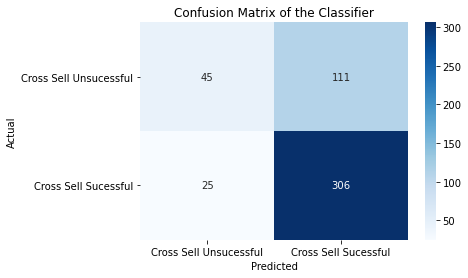

In [52]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = lr_tuned_pred,
          labels = ['Cross Sell Unsucessful', 'Cross Sell Sucessful'])

# CLASSIFICATION TREE

----------------------------

In [53]:
# CLASSIFICATION TREE

full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(X_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(X_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(X_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(X_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(X_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(X_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.8999
Full Tree Testing ACCURACY : 0.6037
Full Tree AUC Score: 0.5712


In [54]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 75
False Positives: 81
False Negatives: 112
True Positives : 219



In [55]:
# INSTANTIATING a classification tree object WITH ADDITIONAL VARIABLES: PRUNED TREE
pruned_tree = DecisionTreeClassifier(max_depth = 8,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(X_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(X_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(X_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7272
Testing  ACCURACY: 0.7146
AUC Score        : 0.5985


In [56]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 43
False Positives: 113
False Negatives: 26
True Positives : 305



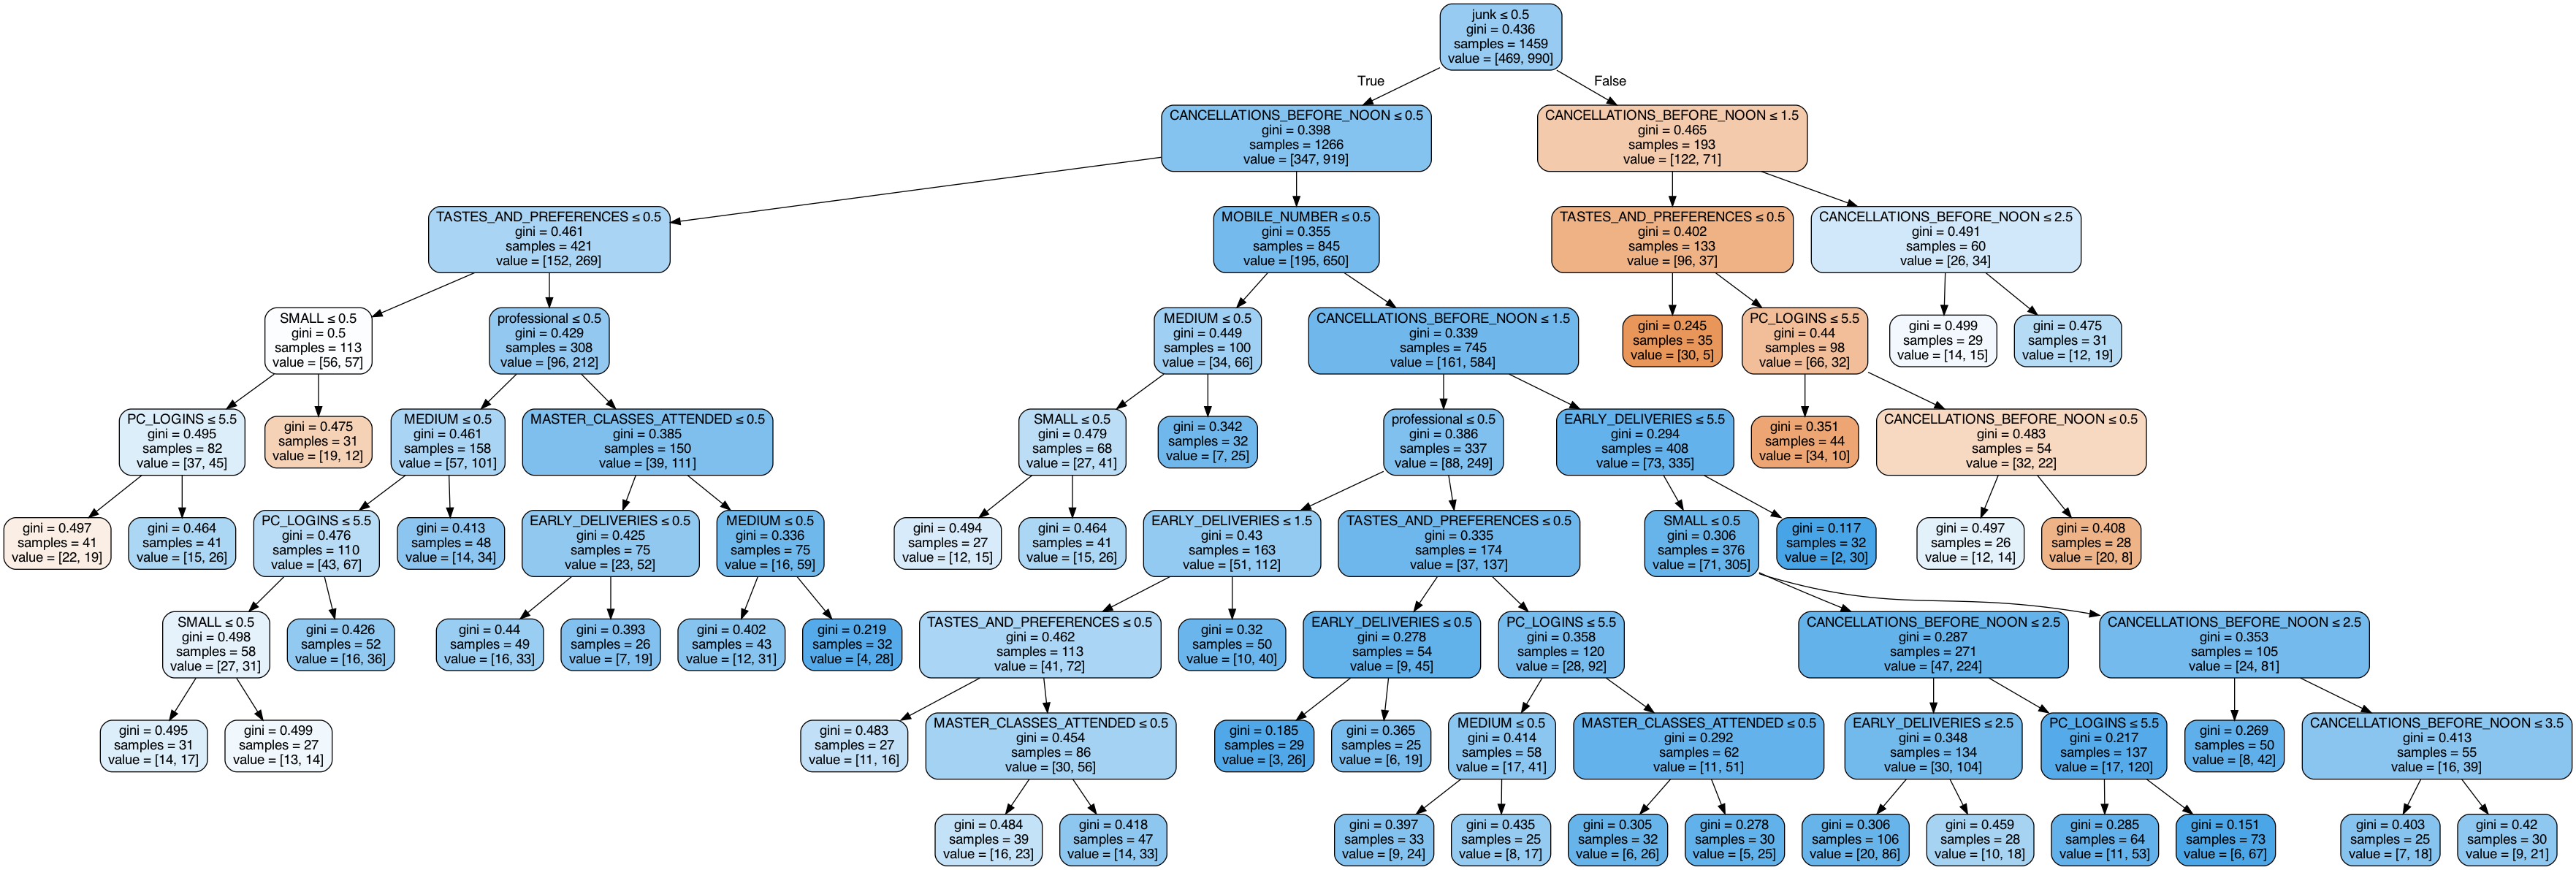

In [57]:
# calling display_tree
display_tree(tree       = pruned_tree_fit,
             feature_df = X_train)

<ipython-input-4-e12d38d703d9>:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


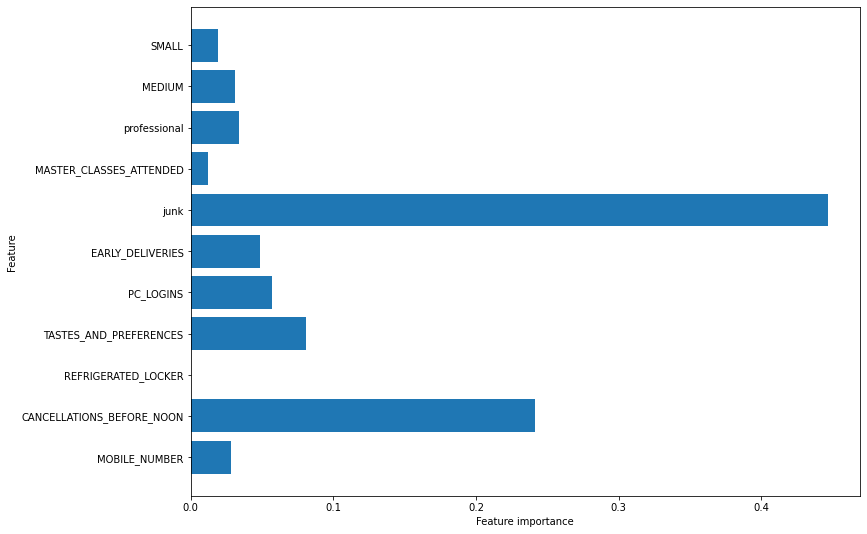

In [58]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train = X_train,
                         export = False)

# TUNED CLASSIFICATION TREE

----------------------------


In [59]:
#CRREATING A TUNED CLASSIFICATION TREE 
# declaring a hyperparameter space
criterion_space = ['gini', 'entropy']
splitter_space  = ['best', 'random']
depth_space     = pd.np.arange(1, 25, 1)
leaf_space      = pd.np.arange(1, 100, 1)


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_space,
              'splitter'         : splitter_space,
              'max_depth'        : depth_space,
              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 5,
                                   n_iter                = 250,
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(cross_selling_data, cross_selling_target)




# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

<ipython-input-59-9d332aa1f509>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  depth_space     = pd.np.arange(1, 25, 1)
<ipython-input-59-9d332aa1f509>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space      = pd.np.arange(1, 100, 1)


Tuned Parameters  : {'splitter': 'random', 'min_samples_leaf': 53, 'max_depth': 7, 'criterion': 'gini'}
Tuned Training AUC: 0.6045


In [60]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
tree_tuned = tuned_tree_cv.best_estimator_





# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(X_test)


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(X_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(X_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.7135
Testing  ACCURACY: 0.7146
AUC Score        : 0.6019


In [61]:
# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 45
False Positives: 111
False Negatives: 28
True Positives : 303



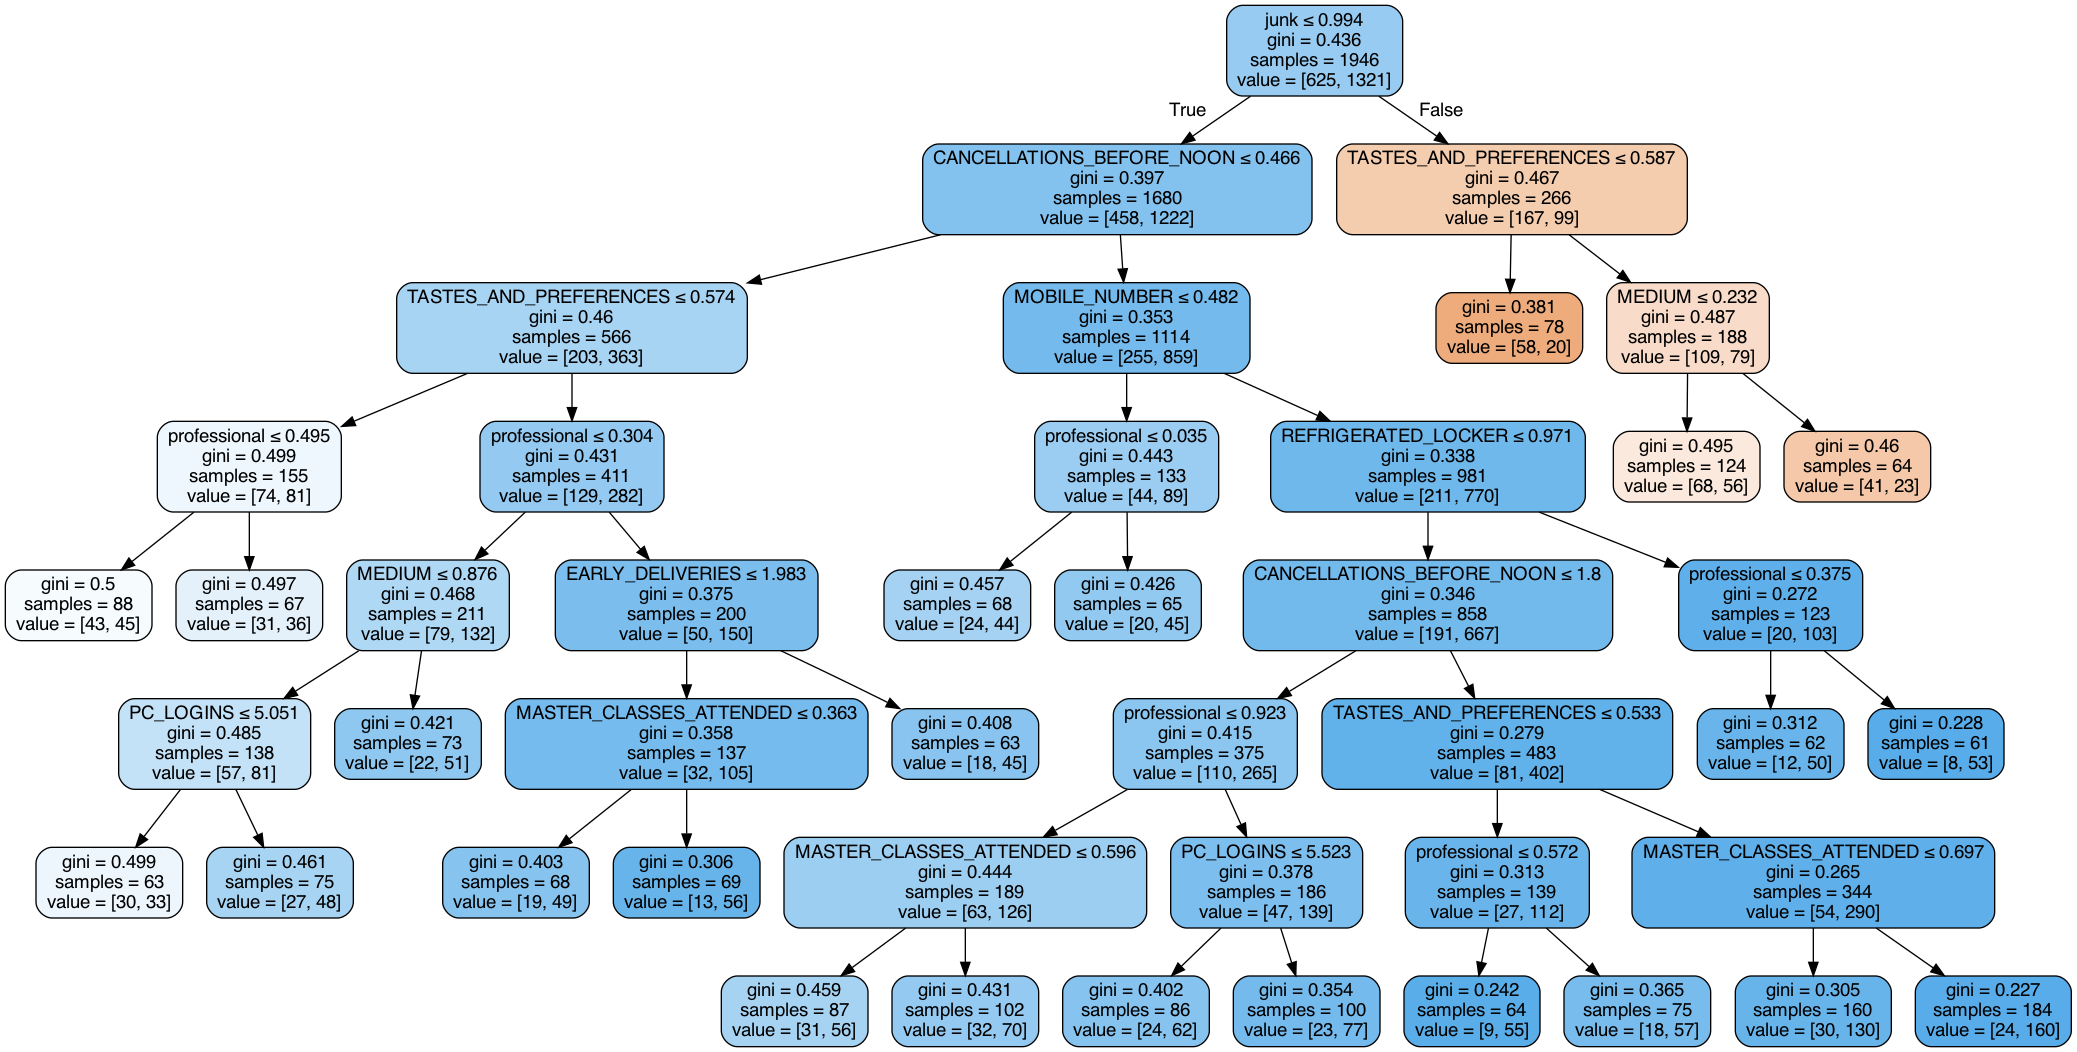

In [62]:
# displaying the tree
display_tree(tree = tree_tuned,
             feature_df = cross_selling_data,
             height = 1500,
             width  = 1500)

# KNN TREE

----------------------------

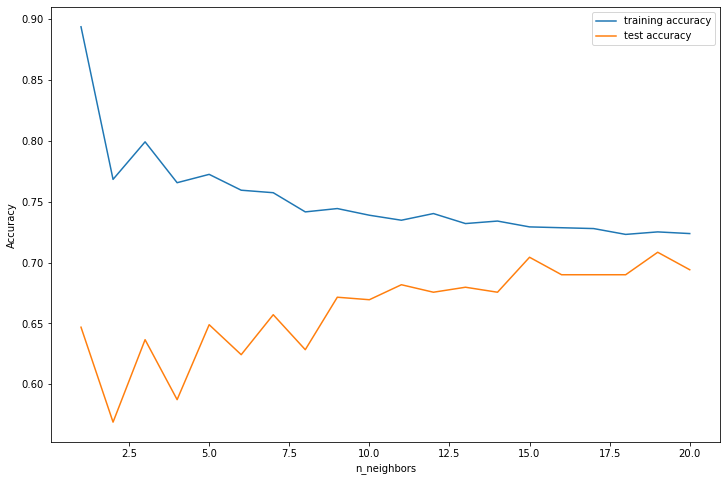

The optimal number of neighbors is: 19


In [63]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data        = cross_selling_data,
                                  y_data        = cross_selling_target,
                                  response_type = 'class')

In [64]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(cross_selling_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(cross_selling_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            cross_selling_target,
            random_state = 219,
            test_size = 0.25,
            stratify = cross_selling_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(X_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(X_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.7231
Testing  ACCURACY: 0.7023
AUC Score        : 0.5844


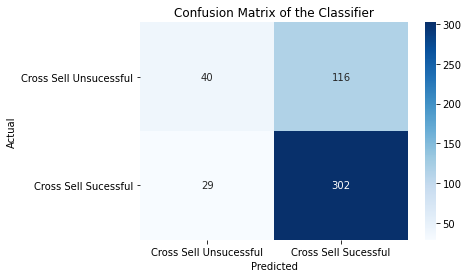

In [65]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = knn_pred,
          labels = ['Cross Sell Unsucessful', 'Cross Sell Sucessful'])

In [66]:
# unpacking the confusion matrix
knn_tree_tn, \
knn_tree_fp, \
knn_tree_fn, \
knn_tree_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 43
False Positives: 113
False Negatives: 26
True Positives : 305



In [77]:
# comparing results
print(f"""
Model         AUC Score         TN, FP, FN, TP
-----         ---------         --------------
Tune Logistic {lr_tuned_auc}          {lr_tuned_tn,lr_tuned_fp,lr_tuned_fn, lr_tuned_tp}
Pruned Tree   {pruned_tree_auc_score}          {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
KNN           {knn_auc_score}          {knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp}
Tune Tree     {tree_tuned_auc}          {tuned_tree_tn, tuned_tree_fp, tuned_tree_fn, tuned_tree_tp}""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Tune Logistic','KNN' , 'Pruned Tree','Tune Tree'],
           
    'AUC Score' : [lr_tuned_auc, knn_auc_score,pruned_tree_auc_score,tree_tuned_auc],
    
    'Training Accuracy' : [lr_tuned_train_score,knn_train_score, 
                           pruned_tree_train_score,tree_tuned_train_score],
           
    'Testing Accuracy'  : [lr_tuned_test_score,knn_train_score, 
                           pruned_tree_test_score,tree_tuned_test_score],

    'Confusion Matrix'  : [(lr_tuned_tn,lr_tuned_fp,lr_tuned_fn, lr_tuned_tp),
                          (knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           
                          (tuned_tree_tn, tuned_tree_fp, tuned_tree_fn, tuned_tree_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)

model_performance



Model         AUC Score         TN, FP, FN, TP
-----         ---------         --------------
Tune Logistic 0.6065          (45, 111, 25, 306)
Pruned Tree   0.5985          (43, 113, 26, 305)
KNN           0.5844          (40, 116, 29, 302)
Tune Tree     0.6019          (45, 111, 28, 303)


,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Tune Logistic,0.6065,0.7197,0.7207,"(45, 111, 25, 306)"
1,KNN,0.5844,0.7231,0.7231,"(40, 116, 29, 302)"
2,Pruned Tree,0.5985,0.7272,0.7146,"(43, 113, 26, 305)"
3,Tune Tree,0.6019,0.7135,0.7146,"(45, 111, 28, 303)"


# RANDOM FOREST

----------------------------

In [68]:
# INSTANTIATING a random forest model with default valuesyy
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

In [69]:
# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8999
Testing  ACCURACY: 0.6735
AUC Score        : 0.609


<ipython-input-4-e12d38d703d9>:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


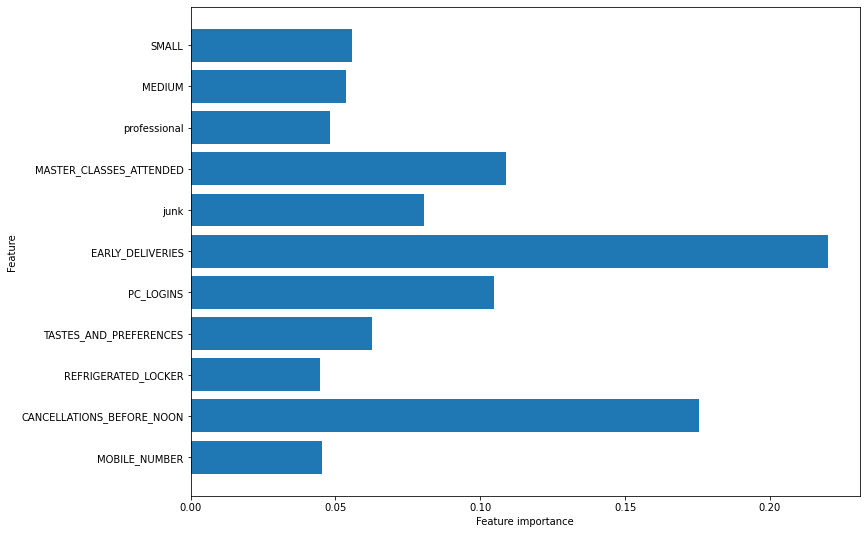

In [70]:
# plotting feature importances
plot_feature_importances(rf_default_fit,
                         train = X_train,
                         export = False)

In [71]:
# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 67
False Positives: 89
False Negatives: 70
True Positives : 261



In [72]:
# declaring model performance objects
rf_train_acc = rf_default_fit.score(X_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(X_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest',
                           'Training Accuracy'  : rf_train_acc,
                           'Testing Accuracy'   : rf_test_acc,
                           'AUC Score'          : rf_auc,
                           'Confusion Matrix'   : (rf_tn,
                                                   rf_fp,
                                                   rf_fn,
                                                   rf_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Tune Logistic,0.6065,0.7197,0.7207,"(45, 111, 25, 306)"
1,KNN,0.5844,0.7231,0.7231,"(40, 116, 29, 302)"
2,Pruned Tree,0.5985,0.7272,0.7146,"(43, 113, 26, 305)"
3,Tune Tree,0.6019,0.7135,0.7146,"(45, 111, 28, 303)"
4,Random Forest,0.6090,0.8999,0.6735,"(67, 89, 70, 261)"


# TUNED RANDOM FOREST

----------------------------

In [73]:
# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# declaring a hyperparameter space
estimator_space  = pd.np.arange(100, 1100, 250)
leaf_space       = pd.np.arange(1, 31, 10)
criterion_space  = ['entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'min_samples_leaf' : leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 5,
                               n_iter     = 250,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(cross_selling_data, cross_selling_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

<ipython-input-73-00f852164e0c>:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  estimator_space  = pd.np.arange(100, 1100, 250)
<ipython-input-73-00f852164e0c>:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space       = pd.np.arange(1, 31, 10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 48 is smaller than n_iter=250. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuned Parameters  : {'warm_start': True, 'n_estimators': 350, 'min_samples_leaf': 1, 'criterion': 'entropy', 'bootstrap': True}
Tuned Training AUC: 0.5982


In [74]:
# building a model based on hyperparameter tuning results

# INSTANTIATING with best_estimator
forest_tuned = forest_cv.best_estimator_


# FIT step not needed


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned.predict(X_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(X_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(X_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                   y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(X_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(X_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.8849
Forest Tuned Testing  ACCURACY: 0.8973
Forest Tuned AUC Score        : 0.8601


In [75]:
# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")


True Negatives : 118
False Positives: 38
False Negatives: 12
True Positives : 319



In [76]:
# declaring model performance objects
tuned_rf_train_acc = forest_tuned.score(X_train, y_train).round(4)
tuned_rf_test_acc  = forest_tuned.score(X_test, y_test).round(4)
tuned_rf_auc       = roc_auc_score(y_true  = y_test,
                                   y_score = forest_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Tuned Random Forest',
                           'Training Accuracy'  : tuned_rf_train_acc,
                           'Testing Accuracy'   : tuned_rf_test_acc,
                           'AUC Score'          : tuned_rf_auc,
                           'Confusion Matrix'   : (tuned_rf_tn,
                                                   tuned_rf_fp,
                                                   tuned_rf_fn,
                                                   tuned_rf_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Tune Logistic,0.6065,0.7197,0.7207,"(45, 111, 25, 306)"
1,KNN,0.5844,0.7231,0.7231,"(40, 116, 29, 302)"
2,Pruned Tree,0.5985,0.7272,0.7146,"(43, 113, 26, 305)"
3,Tune Tree,0.6019,0.7135,0.7146,"(45, 111, 28, 303)"
4,Random Forest,0.6090,0.8999,0.6735,"(67, 89, 70, 261)"
5,Tuned Random Forest,0.8601,0.8849,0.8973,"(118, 38, 12, 319)"


MODEL USED: TUNED RANDOM FOREST
===============